---
title: "Skeleton Service"
format: 
    html:
        toc: true 
        code-fold: false
        code-links:
          - text: Download Quickstart Notebooks
            icon: file-code
            href: https://github.com/AllenInstitute/microns_tutorial/tree/main/tutorial_book/quickstart_notebooks
execute:
    eval: False
    warning: False
jupyter: python3
---

In [1]:
from caveclient import CAVEclient
import meshparty.skeleton_io
import numpy as np

client = CAVEclient("minnie65_public")

### subfunction to convert skeleton

In [2]:
from meshparty import skeleton
def read_skeleton_from_dict(f):
    """
    Helper function for extracting all parts of a skeleton file from a dictionary.

    Parameters
    ----------
    f : dict
        dictionary that includes the constituent elements for building a meshparty skeleon

    Returns
    -------
    :obj:`meshparty.skeleton.Skeleton`
        skeleton object loaded from the dictionary

    """
    
    vertices = np.array(f["vertices"])
    edges = np.array(f["edges"])

    if "mesh_to_skel_map" in f.keys():
        mesh_to_skel_map = f["mesh_to_skel_map"]
    else:
        mesh_to_skel_map = None

    vertex_properties = f["vertex_properties"]

    if "meta" in f.keys():
        meta = f["meta"]
    else:
        meta = {}

    if "root" in f.keys():
        root = f["root"]
    elif "compartment" in vertex_properties.keys():
        root_guess = np.where(np.array(vertex_properties['compartment'])==1)[0]
        if len(root_guess)==1:
            root = root_guess[0] 
        else:
            root = len(edges)
    else:
        root = None

    return skeleton.Skeleton(
        vertices=vertices,
        edges=edges,
        mesh_to_skel_map=mesh_to_skel_map,
        vertex_properties=vertex_properties,
        root=root,
        meta=meta,
    )

## Download skeleton as dictionary

In [3]:
root_id = 864691134918592778
sk_dict = client.skeleton.get_skeleton(root_id, output_format='json')

sk_dict.keys()

dict_keys(['jsonification_version', 'branch_points', 'branch_points_undirected', 'distance_to_root', 'edges', 'end_points', 'end_points_undirected', 'hops_to_root', 'indices_unmasked', 'mesh_to_skel_map', 'mesh_to_skel_map_base', 'meta', 'node_mask', 'root', 'root_position', 'segment_map', 'topo_points', 'unmasked_size', 'vertex_properties', 'vertices'])

## Convert dictionary to meshwork skeleton

In [4]:
# manually generating meshparty skeleton
sk = meshparty.skeleton.Skeleton(
    vertices=np.array(sk_dict['vertices']),
    edges=np.array(sk_dict['edges']),
    mesh_to_skel_map=sk_dict['mesh_to_skel_map'],
    vertex_properties=sk_dict['vertex_properties'],
    root=sk_dict['root'],
    meta=sk_dict['meta'],
)

In [5]:
# with function call
sk = read_skeleton_from_dict(sk_dict)

## Plot with skeleton_plot

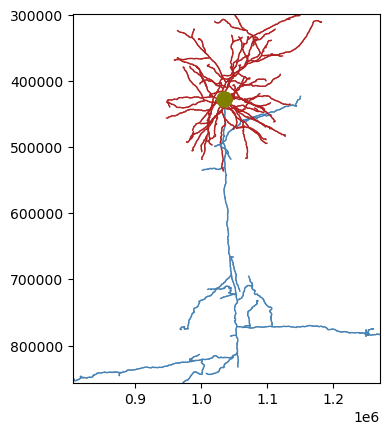

In [6]:
import skeleton_plot

skeleton_plot.plot_tools.plot_skel(sk=sk,
                                   invert_y=True,
                                   pull_compartment_colors=True,
                                   plot_soma=True)

### Estimate path length

In [7]:
# Select the indices associated with the dendrites
sk_compartments = np.array(sk.vertex_properties['compartment'])

dendrite_inds = (sk_compartments==3) | (sk_compartments==4)| (sk_compartments==1) #soma is included here to connect the dendrite graphs 

# create new skeleton that masks (selects) only the dendrite
sk_dendrite = sk.apply_mask(dendrite_inds)
print("Dendrite pathlength of all branches is : ", sk_dendrite.path_length() / 1000, ' um')

Dendrite pathlength of all branches is :  5038.296  um


In [8]:
# Select the indices associated with the dendrites
sk_compartments = np.array(sk.vertex_properties['compartment'])

axon_inds = (sk_compartments==2) 

# create new skeleton that masks (selects) only the axon
sk_axon = sk.apply_mask(axon_inds)
print("Axon pathlength is : ", sk_axon.path_length() / 1000, ' um')

Axon pathlength is :  2666.8994  um


## Estimate synaptic density

In [9]:
# Calculate synapse density (CAVE query)
n_syn_in = len(client.materialize.synapse_query(post_ids=root_id))
n_syn_out = len(client.materialize.synapse_query(pre_ids=root_id))

print("Dendrite synaptic density is : ", n_syn_in / (sk_dendrite.path_length()/1000), ' per um')
print("Axon synaptic density is : ", n_syn_out / (sk_axon.path_length()/1000), ' per um')

Dendrite synaptic density is :  1.3034168  per um
Axon synaptic density is :  0.06861901  per um
